In [11]:
import os
import glob
import zipfile
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
from xml.etree import ElementTree
from xml.dom import minidom
import collections
import seaborn as sns
import pandas as pd
import json
import xml
%matplotlib inline

np.random.seed(42)

In [3]:
cwd = os.getcwd()
# os.chdir('..')
print(cwd)
base_path = cwd
data_folder_name = 'RDD2022'
data_folder_path = os.path.join(cwd, data_folder_name)
extension = ".zip"
dir_name = data_folder_path
print(data_folder_path)
print(dir_name)

c:\Users\tinus\V2023\TDT4265_project
c:\Users\tinus\V2023\TDT4265_project\RDD2022
c:\Users\tinus\V2023\TDT4265_project\RDD2022


In [6]:
def get_dummy_folder_path(dir_name):
    return os.path.join(base_path, dir_name)

In [9]:
def create_dummy_folder(dir_name):
    dummy_folder_base = get_dummy_folder_path(dir_name)
    train_path = os.path.join(dummy_folder_base, 'train')
    annottaions_path = os.path.join(train_path, 'annotations')
    xmls_path = os.path.join(annottaions_path, 'xmls')
    images_path = os.path.join(train_path, 'images')
    if not os.path.exists(xmls_path):
        os.makedirs(xmls_path)
    if not os.path.exists(images_path):
        os.makedirs(images_path)

In [10]:
dummy_folder_name = 'dummy_dataset'
create_dummy_folder(dummy_folder_name)

In [12]:
def draw_boxes_on_image(image, xmin, ymin, xmax, ymax, label, color):
    # Function to draw boundary boxes and labels on the image
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 5)
    cv2.putText(image, label, (int(xmin), int(ymin) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

def display_modified_images_with_boxes(folder_name):
    # Function to display modified images with boundary boxes and labels
    image_folder = os.path.join(base_path, folder_name, 'train', 'images')
    annotation_folder = os.path.join(base_path, folder_name, 'train', 'annotations', 'xmls')

    # Define a color mapping for different labels
    color_mapping = {
        'D00': (0, 255, 0),  # Green
        'D10': (0, 0, 255),  # Blue
        'D20': (255, 0, 0),  # Red
        'D40': (255, 255, 0)  # Yellow
    }

    # Get the list of image files
    image_files = os.listdir(image_folder)

    # Loop through each image file
    for image_file in image_files:
        # Extract the filename without extension
        filename, extension = os.path.splitext(image_file)

        # Check if corresponding XML annotation file exists
        xml_file = os.path.join(annotation_folder, filename + '.xml')
        if not os.path.exists(xml_file):
            print(f"Annotation file not found for image '{image_file}', skipping...")
            continue

        # Load the image
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image '{image_file}', skipping...")
            continue

        # Parse the XML annotation file
        dom = xml.dom.minidom.parse(xml_file)
        root = dom.documentElement
        objects = dom.getElementsByTagName("object")

        # Loop through each object in the annotation
        for obj in objects:
            xmin = float(obj.getElementsByTagName('xmin')[0].childNodes[0].data)
            ymin = float(obj.getElementsByTagName('ymin')[0].childNodes[0].data)
            xmax = float(obj.getElementsByTagName('xmax')[0].childNodes[0].data)
            ymax = float(obj.getElementsByTagName('ymax')[0].childNodes[0].data)
            label = obj.getElementsByTagName('name')[0].childNodes[0].data

            # Get the color for the label from the color mapping
            color = color_mapping.get(label, (255, 255, 255))  # Default color is white

            # Draw the boundary box and label on the image
            draw_boxes_on_image(image, xmin, ymin, xmax, ymax, label, color)

        # Display the modified image with boundary boxes in a Jupyter Notebook
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

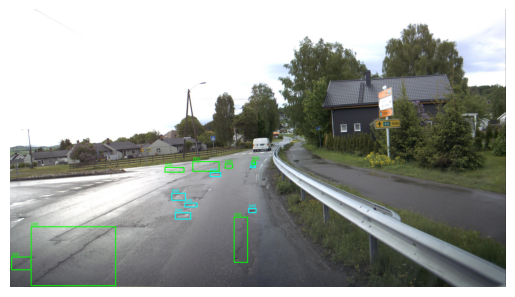

In [13]:
display_modified_images_with_boxes(folder_name=dummy_folder_name)

In [ ]:
augmented_dummy_folder = 'augmented_dummy_dataset'
create_dummy_folder(augmented_dummy_folder)